In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# import logistic regression
from sklearn.linear_model import LogisticRegression
# train test split
from sklearn.model_selection import train_test_split
import json

config_file = "../../mDeepFRI_test/onnx_deepfri_models/DeepFRI-MERGED_GraphConv_gcd_512-512-512_fcd_1024_ca_10.0_bp_model_params.json"
with open(config_file) as f:
    config = json.load(f)
    terms_2_names = {k:v for k, v in zip(config['goterms'], config['gonames'])}

In [2]:
matrix = "/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/Metagenomic-DeepFRI/test_out/prediction_matrix_bp.tsv"
data = pd.read_csv(matrix, sep="\t", index_col=0)

# 1. Influence of net type on predicted scores

**Objective**: To determine if DeepFRI's output features retain architecture-specific artifacts.   
**Method**: DeepFRI employs a GCN for sequence-structure inputs and a CNN for sequence-only inputs. We trained a classifier to predict the specific network architecture used based on the generated feature embeddings.   
**Rationale**: Since the two networks possess different weights and inductive biases, we expect the 'network type' to be a confounding factor that is distinguishable in the latent space.

In [3]:
# use network_type as independent variable for logistic regression
features = data.columns[1:].tolist()
X_train, X_test, y_train, y_test = train_test_split(data[features], data['network_type'], test_size=0.2, random_state=42, stratify=data['network_type'])

# standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# encode network_type to binary
y_train = y_train.map({'gcn': 1, 'cnn': 0})
y_test = y_test.map({'gcn': 1, 'cnn': 0})
# fit logistic regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
# predict
y_pred = logreg.predict(X_test)
# accuracy
accuracy = logreg.score(X_test, y_test)
print(f'Logistic Regression Accuracy: {accuracy*100:.2f}%')

Logistic Regression Accuracy: 98.55%


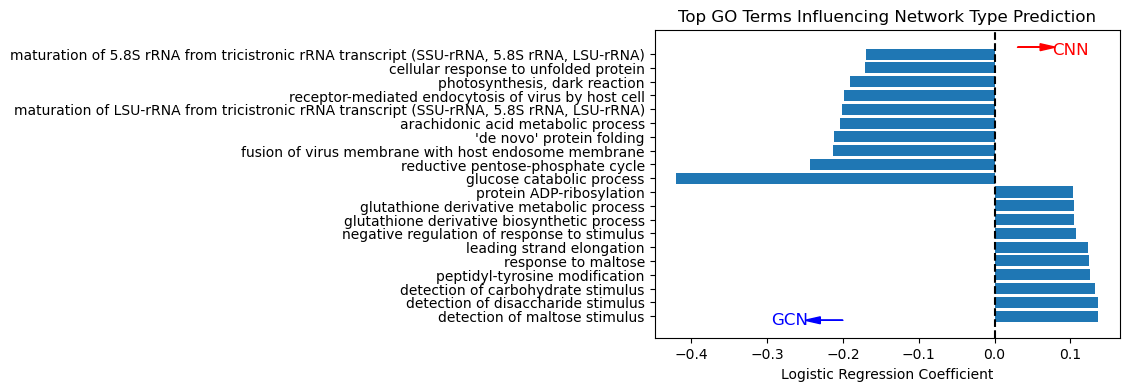

In [4]:
# check coefficients
coefficients = logreg.coef_
# get feature names
feature_names = features
# create dataframe of coefficients
coef_df = pd.DataFrame(coefficients, columns=feature_names)
# get top 10 positive and negative coefficients
top_positive_coefficients = coef_df.T.nlargest(10, 0)
top_ngative_coefficients = coef_df.T.nsmallest(10, 0)
top_coefficients = pd.concat([top_positive_coefficients, top_ngative_coefficients])
# rename 0 column
top_coefficients.columns = ['coefficient']
# add go names
top_coefficients["goname"] = top_coefficients.index.map(terms_2_names)
# plot coefficients, color by positive and negative
plt.figure(figsize=(6,4))
# plot forest plot
plt.barh(top_coefficients.goname, top_coefficients['coefficient'])

# add vertical line at 0
plt.axvline(x=0, color='black', linestyle='--')
plt.xlabel('Logistic Regression Coefficient')
plt.title('Top GO Terms Influencing Network Type Prediction')
# add GCN on the left bottom and CNN on the right bottom with arrows
plt.text(-0.27, -0.6, 'GCN', fontsize=12, color='blue', ha='center')
# add arrow
plt.arrow(-0.2, -0.3, -0.03, 0, head_width=0.5, head_length=0.02, fc='blue', ec='blue')
plt.text(0.1, 19, 'CNN', fontsize=12, color='red', ha='center')
plt.arrow(0.03, 19.5, 0.03, 0, head_width=0.5, head_length=0.02, fc='red', ec='red')
plt.show()

# Conclusions
Net type has an influence on GO-term prediction. Therefore it is advisible to avoid plotting vectors from CNN and GCN together in the same plot, as it might confound interpretation.  

# PCA on GCN proteins

In [5]:
# do a PCA of columns [1:] and network_type=GCN
pca_data = data[data['network_type'] == 'gcn']

features = pca_data.columns[1:].tolist()
# Standardizing the features
x = StandardScaler().fit_transform(pca_data[features])
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

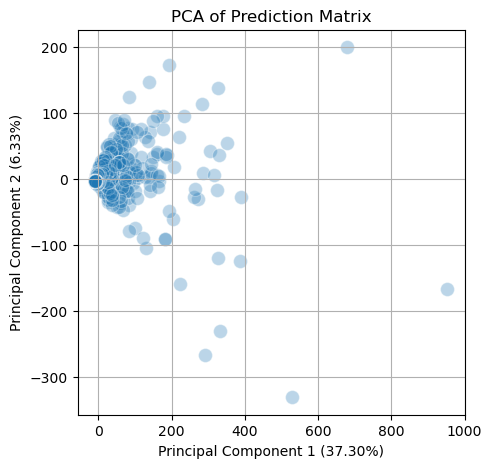

In [6]:
# plot and color by network_type
plt.figure(figsize=(5,5))
sns.scatterplot(x='principal component 1', y='principal component 2', data=principalDf, s=100, alpha=0.3)
plt.title('PCA of Prediction Matrix')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.grid()
plt.show()

In [7]:
# pull out protein with PC1 > 800
outliers = principalDf[principalDf['principal component 1'] > 800]
outliers = data.iloc[outliers.index]
# for each , get GO terms with prediction score > 0.1
# print protein id and GO terms, and their names
for index, row in outliers.iterrows():
    protein_id = row.name
    go_terms = []
    for term in features:
        if row[term] > 0.5:
            go_terms.append((term, terms_2_names[term], row[term]))
    print(f'Protein ID: {protein_id}')
    # sort go_terms by score descending
    go_terms = sorted(go_terms, key=lambda x: x[2], reverse=True)
    for term, name, score in go_terms:
        print(f'{term}\t{name}\t{score:.3f}')

Protein ID: 562.PRJEB4685.GCA_000731455_02417
GO:0048518	positive regulation of biological process	0.580
GO:0048522	positive regulation of cellular process	0.535
GO:0007154	cell communication	0.526
GO:0023052	signaling	0.511
GO:0048519	negative regulation of biological process	0.508


In [8]:
# calculate pairwise cosine similarity between all rows
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(data[features])
# convert to dataframe
cosine_sim_df = pd.DataFrame(cosine_sim, index=data.index, columns=data.index)

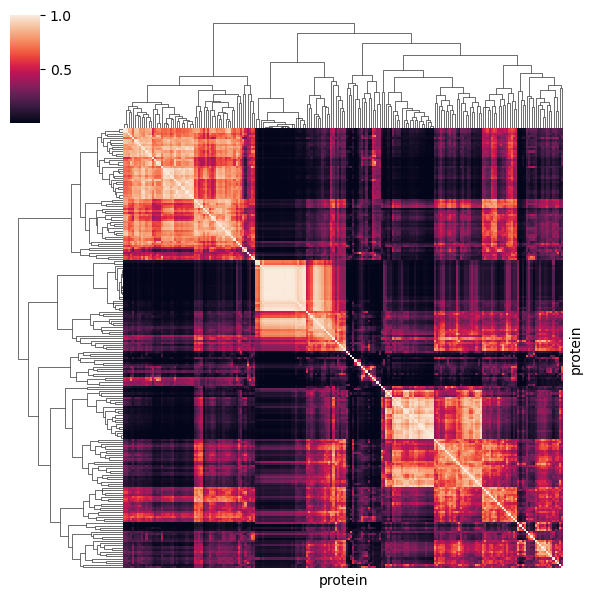

In [9]:
from scipy.spatial import distance
from scipy.cluster import hierarchy


row_linkage = hierarchy.linkage(
    distance.pdist(cosine_sim_df.iloc[:200, :200]), method='average')

col_linkage = hierarchy.linkage(
    distance.pdist(cosine_sim_df.T.iloc[:200, :200]), method='average')

sns.clustermap(cosine_sim_df.iloc[:200, :200], row_linkage=row_linkage, col_linkage=col_linkage, method="average", figsize=(6, 6),
               # remove x and y ticks
                xticklabels=False, yticklabels=False
               )

In [10]:
# get first big cluster
cluster_assignments = hierarchy.fcluster(row_linkage, t=1.5, criterion='distance')
first_cluster_indices = np.where(cluster_assignments == 1)[0]
first_cluster_proteins = data.iloc[first_cluster_indices]

In [11]:
# for each protein
# remove all predictions below 0.5
# add GO terms frequencies

first_cluster_go_terms = {}

for index, row in first_cluster_proteins.iterrows():
    go_terms = row[features][row[features] >= 0.1].index.tolist()
    for term in go_terms:
        if term in first_cluster_go_terms:
            first_cluster_go_terms[term] += 1
        else:
            first_cluster_go_terms[term] = 1

In [13]:
# order by frequency descending
first_cluster_go_terms = dict(sorted(first_cluster_go_terms.items(), key=lambda item: item[1], reverse=True))
# print frequency and GO names
for term, freq in first_cluster_go_terms.items():
    print(f'{term}\t{terms_2_names[term]}\t{freq}')

GO:0006811	ion transport	30
GO:0034220	ion transmembrane transport	29
GO:0006810	transport	29
GO:0055085	transmembrane transport	29
GO:0051234	establishment of localization	29
GO:0006820	anion transport	24
GO:0006812	cation transport	15
GO:0071702	organic substance transport	13
GO:0098655	cation transmembrane transport	13
GO:0071705	nitrogen compound transport	12
GO:0098660	inorganic ion transmembrane transport	12
GO:0098662	inorganic cation transmembrane transport	10
GO:0098656	anion transmembrane transport	8
GO:0006091	generation of precursor metabolites and energy	8
GO:0051716	cellular response to stimulus	8
GO:0022900	electron transport chain	7
GO:0033036	macromolecule localization	6
GO:0007154	cell communication	6
GO:0023052	signaling	6
GO:0007165	signal transduction	6
GO:0042221	response to chemical	5
GO:0016043	cellular component organization	5
GO:0042886	amide transport	4
GO:0006796	phosphate-containing compound metabolic process	3
GO:0032501	multicellular organismal process	3


It is possible, that first cluster contains transmembrane transporters, particularly for ions.